# Clustering con autoencoders

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model


%matplotlib inline
%load_ext autoreload
%autoreload 2

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

In [2]:
# Ejecutar primero el archivo de lectura_datos.py en caso de que no exista covid_periodos.shp
np.random.seed(656413)
dir_principal = os.getcwd()
dir_datos = dir_principal+'\\datos'

covid = gpd.read_file(dir_datos+'/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]
covid_ult_mes = covid_acum.loc[pd.IndexSlice[:,'2021-07'],:]
covid_ult_mes = covid_ult_mes.reset_index(level = 'mes', drop = True)

#casos cada 10 mil habitantes
fallecidos = covid2.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
positivos = covid2.clasificac/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
falle = covid2.fallecido/(covid2.personas/10000)

# Calculamos el coeficiente de localización
from lq import *
lq_ = lq(covid2,'fallecido','clasificac')
lq_fall_conf = lq_[2]
ind_fall_conf = lq_[0]

#la variable se elige para comparar con diferentes opciones
variable = fallecidos #covid2[['clasificac','personas']]

C:\Users\Pablo\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


D:\Codigos\COVID\lq.py:361: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid


las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


In [3]:
import sklearn.pipeline
import sklearn.preprocessing
import procesos

pipe_coord = sk.pipeline.Pipeline([
    ('periodos', procesos.peri_columna()),
    ('coordenadas', procesos.agrega_centroides(centroides))
])

norm_l1 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
     ('norm_l1', sk.preprocessing.Normalizer('l1'))])
norm_l2 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
    ('norm_l2', sk.preprocessing.Normalizer('l2'))])

pipe = sk.pipeline.Pipeline([
    ('coord', pipe_coord),
    ('norml1', norm_l1)])


In [4]:
X = norm_l2.fit_transform(pipe_coord.fit_transform(fallecidos))
X

array([[ 0.10501657,  0.06491797,  0.03989889, ..., -0.30504769,
         0.8518715 , -0.30988538],
       [-0.13974693, -0.09065396, -0.11885757, ..., -0.377653  ,
         0.76425008, -0.27682394],
       [ 0.175485  ,  0.16144447,  0.1575493 , ..., -0.14007865,
         0.87688178, -0.32242928],
       ...,
       [ 0.07029931,  0.03325526, -0.0181941 , ..., -0.27365896,
        -0.46335219,  0.80165502],
       [ 0.40327886,  0.38115879,  0.37183734, ...,  0.21878833,
        -0.15559577, -0.50531809],
       [ 0.33493252,  0.32738978,  0.32430912, ...,  0.13168887,
        -0.1624785 , -0.70743894]])

In [5]:
X.shape

(525, 9)

In [6]:
entrada = layers.Input(shape = (9,))
encoder = layers.Dense(3, activation = "relu")(entrada)
decoder = layers.Dense(9, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 36        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 518us/sample - loss: -0.3218
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3265
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3310
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3353
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3395
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3434
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3470
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3504
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3535
Epoch 10/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3563
Epoch 11/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3589
Epoch 12/50
525/525 [====================

In [8]:
encoded_input = layers.Input(shape = (3,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

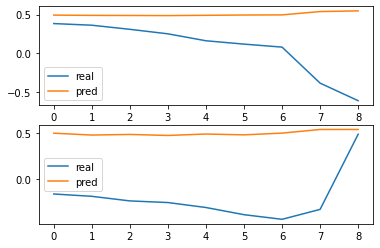

In [10]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [11]:
encoded_valores

array([[0.15078302, 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.3193698 , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.24798913, 0.        , 0.        ],
       [0.20353876, 0.00714755, 0.        ]], dtype=float32)

In [12]:
import sklearn.cluster as clust 
km = clust.KMeans()
km.fit(encoded_valores)
km.labels_

array([7, 0, 1, 1, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 3, 5, 1, 1, 3, 1,
       1, 1, 1, 5, 1, 1, 1, 7, 1, 7, 5, 1, 5, 1, 0, 5, 1, 1, 1, 0, 3, 3,
       1, 5, 5, 2, 5, 3, 3, 1, 1, 5, 1, 0, 5, 5, 1, 7, 0, 1, 0, 1, 0, 3,
       1, 1, 5, 1, 1, 4, 0, 7, 1, 1, 1, 1, 1, 5, 1, 3, 1, 5, 1, 1, 5, 5,
       5, 3, 3, 5, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 1, 3, 1, 0, 1, 1, 5,
       1, 5, 1, 3, 0, 1, 5, 0, 0, 1, 5, 7, 5, 1, 3, 5, 3, 3, 1, 1, 1, 1,
       5, 1, 1, 1, 5, 1, 0, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3,
       6, 7, 0, 2, 6, 0, 0, 0, 3, 7, 2, 7, 6, 0, 0, 0, 3, 0, 0, 0, 7, 5,
       0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 3, 6,

In [13]:
import sklearn.metrics as met 
met.silhouette_score(encoded_valores, km.labels_)

0.72241

In [14]:
met.silhouette_score(X, km.labels_)

0.12243111984868967

In [15]:
from lq import *
lqcovid = lq_peri(covid2[['clasificac','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.8137755102040817

In [16]:
aglo = clust.AgglomerativeClustering(n_clusters = 30)
aglo.fit(encoded_valores)
met.silhouette_score(encoded_valores, aglo.labels_)

0.7504971

In [17]:
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.8418719211822661

<AxesSubplot:>

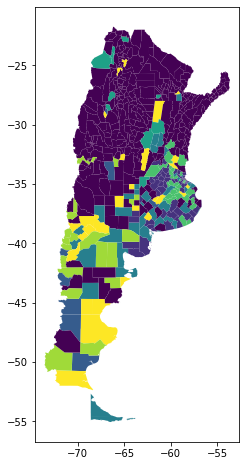

In [18]:
covid_acum_geo = covid_ult_mes.copy()
covid_acum_geo['geometry'] = geo
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8))

<AxesSubplot:>

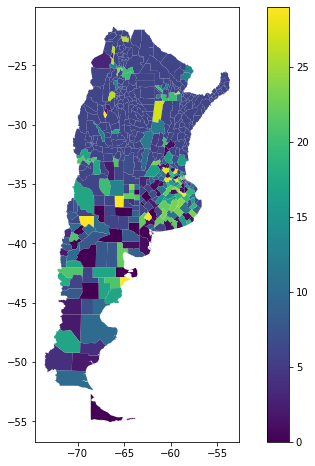

In [19]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [ ]:
variable = (covid_acum.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)).fillna(0)
X = norm_l2.fit_transform(pipe_coord.fit_transform(variable))
X.shape

In [21]:
entrada = layers.Input(shape = (19,))
encoder = layers.Dense(5, activation = "relu")(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(19, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "mse")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 100       
_________________________________________________________________
dense_3 (Dense)              (None, 19)                114       
Total params: 214
Trainable params: 214
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 292us/sample - loss: 0.3159
Epoch 2/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3151
Epoch 3/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3143
Epoch 4/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3135
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3127
Epoch 6/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3119
Epoch 7/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3111
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3103
Epoch 9/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3096
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3088
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3080
Epoch 12/50
525/525 [==============================]

In [23]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

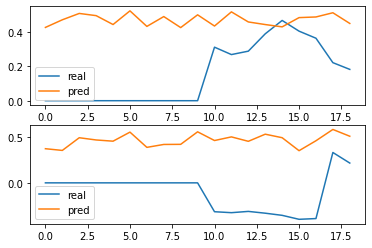

In [24]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [25]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.4608097

In [26]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.6355042016806722

In [27]:
met.silhouette_score(X, km.labels_)

0.19893504708338075

In [28]:
from tensorflow.keras import regularizers
peri = procesos.peri_columna()
X = peri.fit_transform(variable)
X = norm_l2.fit_transform(X)
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(17, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 17)                102       
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [29]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 566us/sample - loss: 1.4475
Epoch 2/50
525/525 [==============================] - 0s 21us/sample - loss: 1.2954
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 1.1475
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 1.0037
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: 0.8640
Epoch 6/50
525/525 [==============================] - 0s 19us/sample - loss: 0.7295
Epoch 7/50
525/525 [==============================] - 0s 19us/sample - loss: 0.6034
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.4816
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: 0.3659
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.2612
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.1653
Epoch 12/50
525/525 [==============================]

In [30]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [31]:
cent = procesos.agrega_centroides(centroides)
encoded_valores = cent.fit_transform(encoded_valores)
encoded_valores = norm_l1.fit_transform(encoded_valores)

In [32]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.4306750612129954

In [33]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.5598739495798319

<AxesSubplot:>

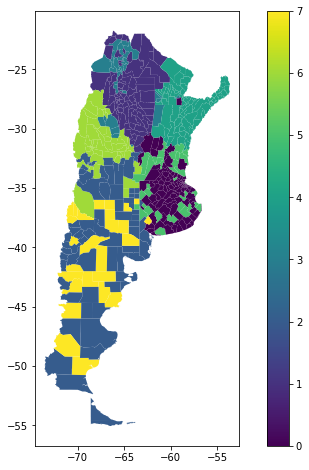

In [34]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [35]:
aglo = clust.AgglomerativeClustering(n_clusters = 15)
aglo.fit(encoded_valores)

AgglomerativeClustering(n_clusters=15)

In [36]:
met.silhouette_score(encoded_valores, aglo.labels_)

0.3726856579572361

In [37]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.49411764705882355

<AxesSubplot:>

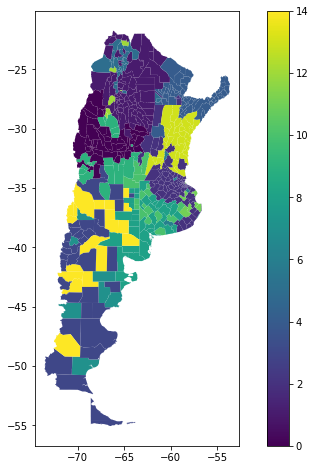

In [38]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [39]:
db = clust.DBSCAN(eps = 0.2, min_samples = 10).fit(encoded_valores)

In [40]:
met.silhouette_score(encoded_valores, db.labels_)

0.47149088727484145

In [41]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(db.labels_)

0.5294117647058824

<AxesSubplot:>

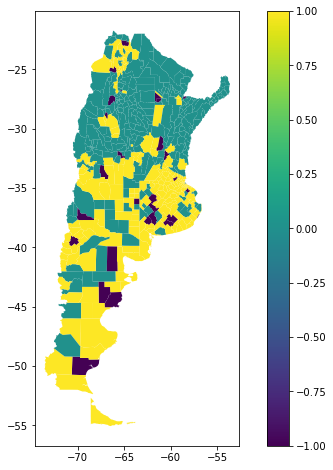

In [42]:
gpd.GeoDataFrame(covid_acum_geo).plot(db.labels_, figsize = (10,8), legend = True)

## positivos y confirmados

In [43]:
datos = covid_acum.apply(lambda x: x/covid_acum.personas*10000)[['clasificac','fallecido']]
X = pipe.fit_transform(datos)
X.shape

(525, 36)

In [44]:
geom = X[:,-2:]
temp = X[:,:-2]
temp

array([[ 0.01019815,  0.02255377,  0.28484866, ..., -0.00269762,
        -0.00582242, -0.00754496],
       [ 0.07559766,  0.02291428,  0.05604072, ..., -0.02123058,
        -0.02908875, -0.03628396],
       [ 0.0487999 ,  0.02010549,  0.06549028, ...,  0.00161269,
        -0.00326928, -0.0066822 ],
       ...,
       [ 0.02392621,  0.00505088, -0.00231598, ..., -0.00580062,
        -0.01395431, -0.01703127],
       [ 0.0056541 ,  0.00464607,  0.00065598, ...,  0.02104742,
         0.01789335,  0.01745624],
       [ 0.1432737 ,  0.09345447,  0.05301385, ...,  0.01337681,
         0.01034025,  0.00910384]])

In [45]:
X = temp
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(X.shape[1], activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 175       
_________________________________________________________________
dense_7 (Dense)              (None, 34)                204       
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [46]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 360us/sample - loss: 2.7942
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: 2.5177
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 2.2553
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 2.0074
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: 1.7694
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: 1.5411
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: 1.3249
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 1.1219
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: 0.9350
Epoch 10/50
525/525 [==============================] - 0s 21us/sample - loss: 0.7637
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.6063
Epoch 12/50
525/525 [==============================]

In [47]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [48]:
X = np.c_[encoded_valores,geom]
km.fit(X)

KMeans()

In [49]:
met.silhouette_score(X, km.labels_)

0.4229472860223095

In [50]:
lqcovid_f = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid_f.calcular_indice_debil(km.labels_)

0.5703781512605042

In [51]:
lqcovid_p = lq_peri(covid_acum[['clasificac','personas']])
1-lqcovid_p.calcular_indice_debil(km.labels_)

0.7699579831932772

In [52]:
aglo.fit(X)
met.silhouette_score(X, aglo.labels_)

0.3801238206969107

In [53]:
lqcovid_f.calcular_indice_debil(aglo.labels_)

0.49411764705882344

In [54]:
lqcovid_p.calcular_indice_debil(aglo.labels_)

0.20784313725490194

<AxesSubplot:>

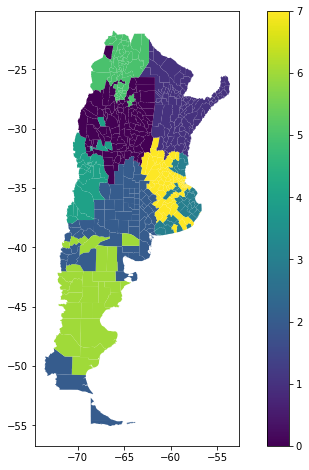

In [55]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [56]:
#def tabla_rdos(datos,model)
model = km
datos_rdos = peri.fit_transform(datos)
datos_rdos = pd.DataFrame(datos_rdos) 
datos_rdos = datos_rdos.groupby(model.labels_).sum()
datos_rdos = datos_rdos.values.reshape(model.n_clusters,2,17)

In [57]:
datos_rdos

array([[[1.08107636e+01, 5.55632112e+01, 1.06915971e+02, 1.76646924e+02,
         1.14117329e+03, 1.98022402e+03, 4.68020997e+03, 9.31695712e+03,
         1.30564017e+04, 1.50978785e+04, 1.89114686e+04, 2.20346612e+04,
         2.60827192e+04, 3.55954682e+04, 5.20890896e+04, 7.11767889e+04,
         8.59515920e+04],
        [2.11639813e+00, 7.93529558e+00, 1.66299092e+01, 2.44736603e+01,
         2.94036993e+01, 5.15740944e+01, 1.27996384e+02, 2.51722709e+02,
         3.23419290e+02, 3.73149885e+02, 4.29986058e+02, 4.75152034e+02,
         5.35175307e+02, 7.05135093e+02, 1.02604869e+03, 1.39613472e+03,
         1.59466125e+03]],

       [[8.63224326e+00, 3.42805403e+01, 7.56664321e+01, 2.27439776e+02,
         4.70962202e+02, 9.38437950e+02, 1.91996463e+03, 3.92847794e+03,
         6.70062997e+03, 9.55058939e+03, 1.39916433e+04, 1.63114084e+04,
         1.99372001e+04, 2.54707389e+04, 3.74021956e+04, 5.03227493e+04,
         6.15309659e+04],
        [5.68065873e-01, 6.95321352e+00, 1.5

In [58]:
model.n_clusters

8

In [59]:
len(lqcovid_f.interv_lqs)

17

In [60]:
lqcovid_f.matriz_intersec_deb.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
lqcovid_f.calcular_indice(km.labels_)

0.0

In [62]:
lqcovid_f.matriz_intersec

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [63]:
np.unique(km.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [64]:
datos['fallecido'].loc[pd.IndexSlice[:,'2020-03']].groupby(km.labels_).sum()

0    2.116398
1    0.568066
2    2.878780
3    1.297744
4    0.376842
5    0.262728
6    0.205903
7    7.510602
Name: fallecido, dtype: float64

In [65]:
datos_rdos[0][0][np.random.randint(0,20,17) > 12]

array([ 4680.20996902, 22034.66120592, 26082.71923947])

In [66]:
np.random.randint(0,20,17) > 12

array([False,  True,  True, False, False, False, False, False, False,
        True, False,  True, False, False, False, False, False])

In [67]:
eva = evaluaciones_lq(km.labels_, ['fallecido','clasificac'], 'personas')

In [68]:
eva.calcular_indices(covid_acum)

{'fallecido': (0.42962184873949577, 44.250020349727556),
 'clasificac': (0.2300420168067227, 1455.4977425656782)}

In [69]:
# determinamos que grupo es el que menos intersecciones tiene
eva.rdos_glob['fallecido']['lqperi'].matriz_intersec_deb.mean(axis = 1)

array([0.26470588, 0.19852941, 0.25735294, 0.28676471, 0.36764706,
       0.32352941, 0.36029412, 0.07352941])

In [70]:
# calculamos la homogeneidad del grupo mas separado de todos
np.sqrt(eva.rdos_loc['fallecido']['regiones'][0]['indices'])

array([33.66575931, 43.80490085])

<AxesSubplot:>

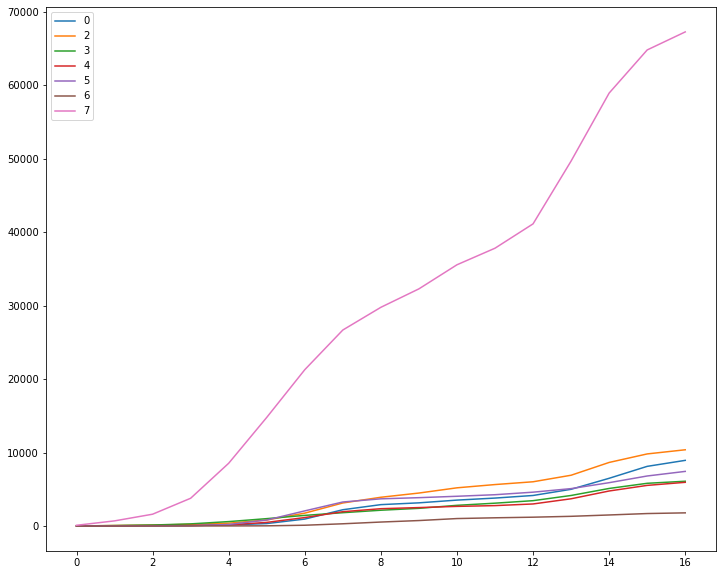

In [71]:
filtro = km.labels_ != 1
labels = km.labels_[km.labels_ != 1]
eva.bd_locales['fallecido'].iloc[:,:-1][filtro].groupby(labels).sum().T.plot(figsize = (12,10))

In [72]:
eva.rdos_glob['clasificac']['lqperi'].matriz_intersec_deb.mean(axis = 1)

array([0.11764706, 0.09558824, 0.05882353, 0.08088235, 0.13235294,
       0.08088235, 0.11764706, 0.05147059])

In [73]:
np.sqrt(eva.rdos_loc['clasificac']['regiones'][2]['indices'])

array([1497.37148457, 2074.8563429 ])

<AxesSubplot:>

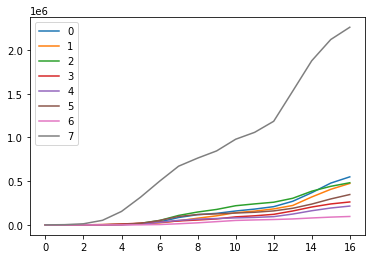

In [74]:
eva.bd_locales['clasificac'].iloc[:,:-1].groupby(km.labels_).sum().T.plot()

In [75]:
total = evaluaciones_lq(np.ones(525), ['fallecido','clasificac'], 'personas')

In [76]:
total.calcular_indices(covid_acum)

D:\Codigos\COVID\lq.py:146: RuntimeWarning: invalid value encountered in double_scalars
  return matriz.sum()/(len(matriz)*(len(matriz)-1))
D:\Codigos\COVID\lq.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return (matriz.sum()/(p*(p-1)))+1/p


{'fallecido': (nan, 86.6842687108971), 'clasificac': (nan, 1955.988361954866)}

In [80]:
pcias = evaluaciones_lq(codiprov.codpcia.values, ['fallecido','clasificac'], 'personas')

In [81]:
pcias.calcular_indices(covid_acum)

{'fallecido': (0.43275788576300084, 38.87194179171308),
 'clasificac': (0.17124893435635122, 982.9989536084058)}

In [95]:
km2 = clust.KMeans(15)

In [96]:
km2.fit(X)

KMeans(n_clusters=15)

<AxesSubplot:>

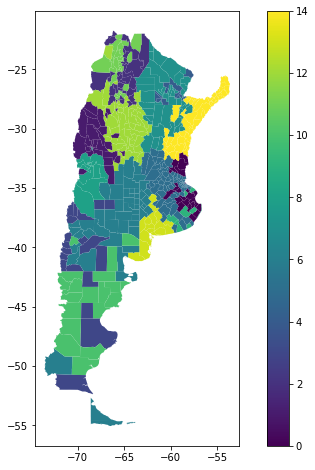

In [97]:
gpd.GeoDataFrame(covid_acum_geo).plot(km2.labels_, figsize = (10,8), legend = True)

In [98]:
km30 = evaluaciones_lq(km2.labels_,  ['fallecido','clasificac'], 'personas')
km30.calcular_indices(covid_acum)

{'fallecido': (0.5366946778711484, 36.31072345112687),
 'clasificac': (0.230812324929972, 1205.4697602407912)}

In [104]:
km30.calcular_indices(covid)

{'fallecido': (0.7647058823529412, 4.669092738012782),
 'clasificac': (0.27899159663865547, 199.90755956137534)}

In [105]:
pcias.calcular_indices(covid)

{'fallecido': (0.6804134697357204, 4.313223080184847),
 'clasificac': (0.23135123614663256, 146.98366027295808)}

In [106]:
total.calcular_indices(covid)

D:\Codigos\COVID\lq.py:146: RuntimeWarning: invalid value encountered in double_scalars
  return matriz.sum()/(len(matriz)*(len(matriz)-1))
D:\Codigos\COVID\lq.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return (matriz.sum()/(p*(p-1)))+1/p


{'fallecido': (nan, 9.775270733496903),
 'clasificac': (nan, 306.30805788070444)}

In [109]:
datos = covid[['clasificac','fallecido']].apply(lambda x: x/covid.personas*10000)
X = pipe.fit_transform(datos)
geom = X[:,-2:]
temp = X[:,:-2]

X = temp
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(X.shape[1], activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

autoencoder.fit(X, X, epochs = 50)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 175       
_________________________________________________________________
dense_9 (Dense)              (None, 34)                204       
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________
Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 351us/sample - loss: 2.9317
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: 2.6554
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 2.3914
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 2.1344
Epoch 5/50
525/525 [============

In [110]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)
X = np.c_[encoded_valores,geom]
km.fit(X)


KMeans()

In [111]:
met.silhouette_score(X, km.labels_)

0.40622004876766077

In [122]:
evaluaciones_lq(km.labels_, ['fallecido','clasificac'], 'personas').calcular_indices(covid)

{'fallecido': (0.6102941176470589, 7.846418231246237),
 'clasificac': (0.259453781512605, 208.11524113279344)}

In [121]:
km.fit(pipe.fit_transform(datos))

KMeans()

In [126]:
pd.DataFrame(X).to_csv('Geodabd/autoencoder.csv')

# Positivos y fallecidos por separado?

In [132]:
X = pipe.fit_transform(datos)
geo = X[:,-2:]
positiv = X[:,:17]
fallec = X[:,17:34]

In [139]:
X = X[:,:-2]
input_falle = layers.Input(shape = (fallec.shape[1],))
input_posit = layers.Input(shape = (positiv.shape[1],))
encoder1 = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(input_falle)
encoder2 = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(input_posit)
concat = layers.concatenate([encoder1,encoder2])
encoder = layers.Dense(5, activation = "relu")(concat)

decoder = layers.Dense(X.shape[1], activation = "sigmoid")(encoder)

autoencoder = Model(inputs = [input_falle,input_posit], outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = [input_falle,input_posit], outputs = encoder)

autoencoder.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 5)            90          input_17[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 5)            90          input_18[0][0]                   
___________________________________________________________________________________________

In [140]:
autoencoder.fit((fallec,positiv), X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 472us/sample - loss: 4.1734
Epoch 2/50
525/525 [==============================] - 0s 23us/sample - loss: 3.8945
Epoch 3/50
525/525 [==============================] - 0s 25us/sample - loss: 3.6235
Epoch 4/50
525/525 [==============================] - 0s 23us/sample - loss: 3.3595
Epoch 5/50
525/525 [==============================] - 0s 25us/sample - loss: 3.1054
Epoch 6/50
525/525 [==============================] - 0s 25us/sample - loss: 2.8633
Epoch 7/50
525/525 [==============================] - 0s 25us/sample - loss: 2.6310
Epoch 8/50
525/525 [==============================] - 0s 23us/sample - loss: 2.4101
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: 2.2001
Epoch 10/50
525/525 [==============================] - 0s 25us/sample - loss: 1.9965
Epoch 11/50
525/525 [==============================] - 0s 21us/sample - loss: 1.8008
Epoch 12/50
525/525 [==============================]

In [142]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict((fallec,positiv))
decoded_valores = decoder.predict(encoded_valores)
X = np.c_[encoded_valores,geom]
km.fit(X)

KMeans()

<AxesSubplot:>

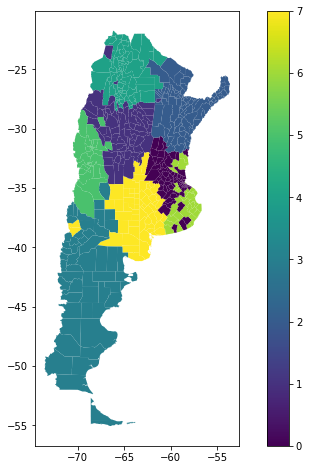

In [143]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [144]:
met.silhouette_score(X, km.labels_)

0.41002505235648046

In [147]:
evaluaciones_lq(km.labels_, ['fallecido','clasificac'], 'personas').calcular_indices(covid_acum)

{'fallecido': (0.4548319327731093, 53.880387531593776),
 'clasificac': (0.24684873949579833, 1403.002859232305)}

In [149]:
km2.fit(X)

KMeans(n_clusters=15)

In [150]:
evaluaciones_lq(km2.labels_, ['fallecido','clasificac'], 'personas').calcular_indices(covid_acum)

{'fallecido': (0.4117647058823529, 44.759791088410275),
 'clasificac': (0.18711484593837535, 1277.1192407438828)}

<AxesSubplot:>

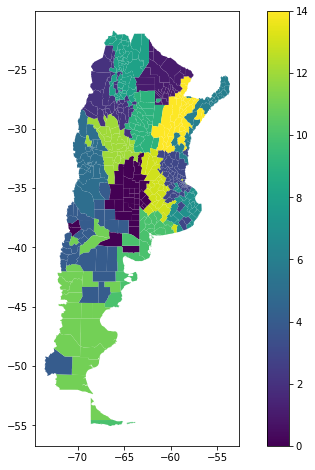

In [152]:
gpd.GeoDataFrame(covid_acum_geo).plot(km2.labels_, figsize = (10,8), legend = True)

In [156]:
km3 = clust.KMeans(n_clusters = 18)
km3.fit(X)
evaluaciones_lq(km3.labels_, ['fallecido','clasificac'], 'personas').calcular_indices(covid_acum)

{'fallecido': (0.4411764705882353, 43.46529976164676),
 'clasificac': (0.19819300269127257, 1164.597227693584)}